### Data Module Example

In [1]:
import pandas as pd
import networkx as nx
import yaml
import torch_geometric.nn as geom_nn
from torch.nn import ReLU, Sigmoid
from typing import Dict, Union, List
import torch
import torch.nn
import torch.nn as nn
from torch.optim import Adam
from torch.nn import functional as F
import torch_geometric.nn as geom_nn
from torch_geometric.data import Data
from pytorch_lightning import LightningModule, Trainer

from app.features.model.layers import GlobalPooling
from app.features.model.layers import Concat
from app.builder.dataset import DataModule
from app.features.model.schema.configs import ModelConfig

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
config = """name: GNNExample
dataset:
  name: Small Zinc dataset
  target_column: tpsa
  feature_columns:
    - smiles
    - mwt

featurizers:
  - name: MolToGraphFeaturizer
    type: app.features.model.featurizers.MoleculeFeaturizer
    input:
      - smiles
    args:
      allow_unknown: false
      sym_bond_list: true
      per_atom_fragmentation: false

layers:

  # Start fst branch (from featurizer)
  - name: GCN1
    type: torch_geometric.nn.GCNConv
    args:
      in_channels: 26
      out_channels: 64
    input: MolToGraphFeaturizer

  - name: GCN1_Activation
    type: torch.nn.ReLU
    input: GCN1

  - name: GCN2 
    type: torch_geometric.nn.GCNConv
    input: GCN1_Activation
    args:
      in_channels: 64
      out_channels: 64

  - name: GCN2_Activation
    type: torch.nn.ReLU
    input: GCN2

  - name: GCN3
    type: torch_geometric.nn.GCNConv
    input: GCN2_Activation
    args:
      in_channels: 64
      out_channels: 64

  - name: GCN3_Activation
    type: torch.nn.ReLU
    input: GCN3

  - name: AddPool
    type: app.features.model.layers.GlobalPooling
    input: GCN3_Activation
    args:
      aggr: 'sum'
  # End of fst branch

  # Second branch would simply be linear layers in mwt
  - name: Linear1
    type: torch.nn.Linear
    args:
      in_features: 1
      out_features: 10
    input: mwt

  - name: Combiner
    type: app.features.model.layers.Concat
    input: ['AddPool', 'Linear1']

  - name: LinearJoined
    type: torch.nn.Linear
    input: Combiner
    args:
      in_features: 74
      out_features: 1
"""

model = ModelConfig.from_yaml(config)
model

ModelConfig(name='GNNExample', dataset=DatasetConfig(name='Small Zinc dataset', target_column='tpsa', feature_columns=['smiles', 'mwt']), featurizers=[AppmoleculefeaturizerLayerConfig(name='MolToGraphFeaturizer', input=['smiles'], type='app.features.model.featurizers.MoleculeFeaturizer', args=AppmoleculefeaturizerArgs(allow_unknown=False, sym_bond_list=True, per_atom_fragmentation=False))], layers=[TorchgeometricgcnconvLayerConfig(name='GCN1', input='MolToGraphFeaturizer', type='torch_geometric.nn.GCNConv', args=TorchgeometricgcnconvArgs(in_channels=26, out_channels=64)), TorchreluLayerConfig(name='GCN1_Activation', input='GCN1', type='torch.nn.ReLU'), TorchgeometricgcnconvLayerConfig(name='GCN2', input='GCN1_Activation', type='torch_geometric.nn.GCNConv', args=TorchgeometricgcnconvArgs(in_channels=64, out_channels=64)), TorchreluLayerConfig(name='GCN2_Activation', input='GCN2', type='torch.nn.ReLU'), TorchgeometricgcnconvLayerConfig(name='GCN3', input='GCN2_Activation', type='torch_ge

In [3]:
zinc = pd.read_csv('./zinc.csv')

In [3]:
data_module = DataModule(zinc, 'random', '80-15-5', 4, model.dataset, model.featurizers)
data_module

In [4]:
data_module.setup()
tl = data_module.train_dataloader()

In [5]:
next(iter(tl))

{'MolToGraphFeaturizer': DataBatch(x=[77, 26], edge_index=[2, 162], edge_attr=[162, 9], batch=[77], ptr=[5]),
 'mwt': tensor([170.5990, 307.4150, 296.3670, 320.4360]),
 'y': tensor([55.1200, 55.4000, 72.6400, 44.8900])}

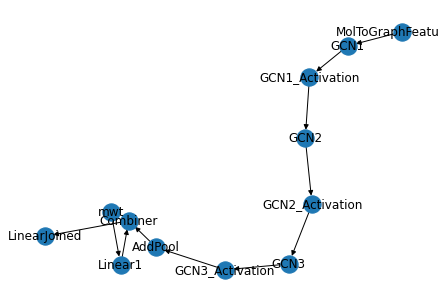

In [4]:
nx.draw(model.make_graph(), with_labels=True)

In [4]:
## Creating the database dataset object
from fastapi.datastructures import UploadFile
from app.db.session import SessionLocal
from app.features.dataset import controller as dataset_ctl
from app.features.dataset.schema import DatasetCreate, Dataset
from app.features.dataset.crud import repo as dataset_repo
from app.features.user.crud import repo as user_repo

ds_file_path = '/app/app/tests/data/csv/zinc.csv'
ds_file = open(ds_file_path, 'rb')
ds_file = UploadFile(ds_file_path, ds_file)
user = None
db = None
if not db:
    db = SessionLocal()
ds = dataset_repo.get_by_name(db, 'Small Zinc dataset')
if not user:
    user = user_repo.get_by_email(db, email='admin@mariner.trident.bio')
    assert user is not None
if not ds:
    ds = dataset_ctl.create_dataset(db, user, DatasetCreate(
        file=ds_file,
        name="Small Zinc dataset",
        description="The dataset with 1 smiles and 1 scalar columns as features and 1 scalar column as target",
        split_target="60-20-20"
    ))
    assert ds is not None
    
# creating pygnn dataset instance
dataset = CustomDataset(ds, model)
dataloader = DataLoader(dataset)
print(next(iter(dataloader)))

/app/app/features/dataset/utils.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats = stats.append(dtypes)
/app/app/features/dataset/utils.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats = stats.append(nacount)


[{'mwt': tensor([[296.3670]]), 'MolToGraphFeaturizer': DataBatch(x=[21, 26], edge_index=[2, 42], edge_attr=[42, 9], batch=[21], ptr=[2])}, tensor([[[72.6400]]])]


In [5]:
edge_index_classes = ( geom_nn.MessagePassing )
pooling_classes = ( GlobalPooling )
activations = (ReLU, Sigmoid)

def is_message_passing(layer):
    """ x = layer(x, edge_index) """
    return isinstance(layer, geom_nn.MessagePassing)

def is_graph_pooling(layer):
    """ x = layer(x, batch) """
    return isinstance(layer, pooling_classes)

def is_concat_layer(layer):
    return isinstance(layer, Concat)

def is_graph_activation(layer, layers_dict, previous):
    """
    takes the a dictionary with nn.Modules and the keys of
    previous layers, checking if 
    """
    if not isinstance(layer, activations):
        return False
    for name in previous:
        if is_message_passing(layers_dict[name]) or is_graph_pooling(layers_dict[name]):
            return True
    return False


### Custom Model

In [13]:
class CustomModel(LightningModule):

    def __init__(self, config: ModelConfig):
        super().__init__()
        
        self.config = config

        layers_dict = {}
        for layer in config.layers:
            layers_dict[layer.name] = layer.create()

        self.layers = torch.nn.ModuleDict(layers_dict)

        self.layer_configs = {
            l.name: l for l in config.layers
        }

        self.graph = config.make_graph()
        self.topo_sorting = list(nx.topological_sort(self.graph))
        
        self.loss_fn = nn.MSELoss()
        
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)
    
    def test_step(self, batch, batch_idx):
        prediction = self(batch).reshape(4,)
        loss = self.loss_fn(prediction, batch['y'])
        # self.logger.log('test_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        prediction = self(batch).reshape(4,)
        loss = self.loss_fn(prediction, batch['y'])
        return loss

    def training_step(self, batch, batch_idx):
        prediction = self(batch).reshape(4,)
        # TODO: adapt loss to problem type. MSE will only work for regression
        loss = self.loss_fn(prediction, batch['y'])
        return loss
    
    def forward(self, input_):
        storage = input_.copy()

        for key, value in storage.items():
            if key != 'y' and not isinstance(value, Data):
                storage[key] = value.reshape(len(value), 1)

        batch_values = None

        for index, node_name in enumerate(self.topo_sorting):
            if not node_name in self.layers:
                continue
            layer_name = node_name
            layer = self.layers[layer_name]
            layer_config = self.layer_configs[layer_name]
            previous_layers = [p_layer for p_layer, c_layer in self.graph.in_edges(layer_name)]
            inputs = if_str_make_list(layer_config.input)
            # Step 2
            # Transform and preprocess the input and output based on the previous
            # and next layers.
            
            if is_message_passing(layer):
                assert len(inputs) == 1, f"Length of a gnn layer's inputs should be at most 1. inputs = {inputs}"
                src = inputs[0]
                assert isinstance(storage[src], Data)
                x, edge_index, batch_values = storage[src].x, storage[src].edge_index, storage[src].batch
                x, edge_index = layer(x=x, edge_index=edge_index), edge_index
                storage[layer_name] = Data(x=x, edge_index=edge_index, batch=batch_values)
            # 2.2   - if its an pooling layer it always have just one input
            #         and the input is composed by x (node_features) from the last layer
            #         and the batch that comes with the data object
            elif is_graph_pooling(layer):
                assert len(inputs) == 1, f"Length of a gnn layer's inputs should be at most 1. inputs = {inputs}"
                src = inputs[0]
                assert isinstance(storage[src], Data)
                x, edge_index, batch_values = storage[src].x, storage[src].edge_index, storage[src].batch
                storage[layer_name] = layer(x=x, batch=batch_values)
            # 2.3   - if its an activation or a mlp/normal layer we need to check the
            #         previous layers to make sure that the input is in t;he correct format
            #         and check the next layers to format the output
            elif is_graph_activation(layer, self.layers, previous_layers):
                assert len(inputs) == 1, f"Length of a activation layer's inputs should be at most 1. inputs = {inputs}"
                src = inputs[0]
                assert isinstance(storage[src], Data)
                x, edge_index, batch_values = storage[src].x, storage[src].edge_index, storage[src].batch
                storage[layer_name] = Data(x=layer(x), edge_index=edge_index, batch=batch_values)
            elif is_concat_layer(layer):
                assert len(inputs) == 2, f"Length of a concat layer's inputs should be 2. inputs = {inputs}"
                x1, x2 = storage[inputs[0]], storage[inputs[1]]
                storage[layer_name] = layer(x1,x2)
            elif isinstance(layer, nn.Linear):
                input_values = [
                    storage[input]
                    for input in inputs
                ]
                input_values = torch.cat(input_values, dim=1)
                x_ = layer(input_values)
                storage[layer_name] = x_
            else:
                input_values = [ 
                    storage[input] if isinstance(storage[input], Data) else
                    storage[input]
                    for input in inputs
                ]
                x_ = layer(*input_values)
                storage[layer_name] = x_
            last = storage[layer_name]
        return last

custom_model = CustomModel(model)
custom_model
# custom_model.forward(x)
# trainer = Trainer(max_epochs=2)
# trainer.fit(custom_model, dataloader)

CustomModel(
  (layers): ModuleDict(
    (GCN1): GCNConv(26, 64)
    (GCN1_Activation): ReLU()
    (GCN2): GCNConv(64, 64)
    (GCN2_Activation): ReLU()
    (GCN3): GCNConv(64, 64)
    (GCN3_Activation): ReLU()
    (AddPool): GlobalPooling(aggr=sum)
    (Linear1): Linear(in_features=1, out_features=10, bias=True)
    (Combiner): Concat()
    (LinearJoined): Linear(in_features=74, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
)

In [7]:
def if_str_make_list(x: Union[str, List[str]]) -> List[str]:
    if isinstance(x, str):
        return [x]
    return x

In [14]:
import pytorch_lightning as pl

trainer = pl.Trainer(max_epochs=10)
trainer

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
data_module = DataModule(zinc, 'random', '80-15-5', 4, model.dataset, model.featurizers)
data_module.setup(stage=None)

trainer.fit(custom_model, data_module.train_dataloader())

Missing logger folder: /app/notebooks/lightning_logs

  | Name    | Type       | Params
---------------------------------------
0 | layers  | ModuleDict | 10.1 K
1 | loss_fn | MSELoss    | 0     
---------------------------------------
10.1 K    Trainable params
0         Non-trainable params
10.1 K    Total params
0.041     Total estimated model params size (MB)


Epoch 9: 100%|████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.58it/s, loss=55.8, v_num=0]


In [16]:
b_ = next(iter(data_module.test_dataloader()))
b_

{'MolToGraphFeaturizer': DataBatch(x=[79, 26], edge_index=[2, 164], edge_attr=[164, 9], batch=[79], ptr=[5]),
 'mwt': tensor([321.3840, 212.2010, 323.3700, 248.2820]),
 'y': tensor([85.8300, 75.9900, 73.8600, 67.7600])}

In [18]:
{
'loss': 55.8,
'mse': 55.8,
}

7.416198487095663

In [17]:
pred = custom_model(b_)
pred

tensor([[83.6066],
        [73.9177],
        [77.2502],
        [63.9825]], grad_fn=<AddmmBackward>)